In [15]:
from typing import List, Union, Any, Tuple, Dict, Callable, Optional, Literal

from pathlib import Path
import numpy as np
import pandas as pd
import re
from scipy.stats import wilcoxon, bootstrap

# Импорт библиотек для Jupyter Notebook
# %matplotlib widget
#%matplotlib notebook
%matplotlib inline
import seaborn as sns
sns.color_palette('colorblind')
import matplotlib.pyplot as plt
# Делаем одинаковый размер картинок в matplotlib notebook и matplotlib inline
import matplotlib as mpl

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['text.antialiased'] = True
from IPython.display import display, display_html, display_latex
import mplcursors

RANDOM_STATE = 17
np.random.seed(RANDOM_STATE)

# -------------- Вспомогательные функции -----------------------
"""Для построения нормальных графиков (с заголовком, подписями осей, ...) надо каждый раз
добавлять соответсвующий вспомогательный код. Чтобы не писать каждый раз одинаковый код,
оформим его в виде декоратора с параметрами
"""


def set_args_to_decorator(decorator_to_enhance):
    """Функция КАК декоратор и ДЛЯ декораторов.

    Должна декорировать другую функцию, которая должна быть декоратором.
    Она даёт возможность любому декоратору принимать произвольные аргументы.
    """

    # Передача аргументов ДЕКОРАТОРА:
    def decorator_maker(*args, **kwargs):
        # создадим декоратор, который принимает как аргумент только
        # функцию, но сохраняет все аргументы, переданные своему "создателю"
        def decorator_wrapper(draw_func):
            # Декоратор должен быть вида decorator(draw_func, *args, **kwargs)
            #  иначе ничего не сработает
            return decorator_to_enhance(draw_func, *args, **kwargs)

        return decorator_wrapper

    return decorator_maker


# Создаём функцию, которую будем использовать как декоратор и декорируем её
# Не стоит забывать, что она должна иметь вид "decorator(draw_func, *args, **kwargs)"
@set_args_to_decorator
def set_plot_env(draw_func: Callable[..., Any],
                 fig_num: Union[int, str] = None,
                 num_rows: int = 1,
                 num_cols: int = 1,
                 fig_in_inches: Tuple[int, int] = (12, 8),
                 xlabel: Union[str, List[str]] = '',
                 ylabel: Union[str, List[str]] = '',
                 use_sharey=False,
                 title: str = '',
                 title_pad: int = 4,
                 label_fntsize: int = 12,
                 title_fntsize: int = 16,
                 major_labelsize: int = 12,
                 minor_labelsize: int = 8,
                 show_legend: bool = False,
                 legend_fontsize: int = 10,
                 is_png: bool = False,
                 fname: Optional[str] = None) -> Callable[..., Any]:
    """Задает основные параметры рисунков

    Может использоваться для создания рисунка из одного графика, рисунка из нескольких графиков, расположенных
    "в столбец" или "в строку" или для "матрицы из графиков".
    Если на рисунке несколько графиков, то ylabel должен содержать список из строк - подписей осей Y,
    при этом xlabel может быть как списком из строк, так и просто строкой
    (тогда подписи всех осей X будут равны этой строке).

    :param draw_func:       Функция, которая рисует график
    :param fig_num:         Номер рисунка, если None, то каждый рисунок нумеруется по порядку выполнения кода
    :param num_rows:        Количество "строк" из графиков
    :param num_cols:        Количество "столбцов" из графиков (число графиков = num_rows * num_cols)
    :param fig_in_inches:   Размер рисунка в дюймах
    :param xlabel:          Подпись оси Х, может быть строкой или списком строк
    :param ylabel:          Подпись оси Y, может быть строкой или списком строк
    :param use_sharey:      Не рисовать вторую ось "Y", если одна ось уже нарисована
    :param title:           Название рисунка
    :param title_pad:       Отступ заголовка рисунка от графиков (в ед. размера шрифта)
    :param label_fntsize:   Размер шрифта для подписей названия осей
    :param title_fntsize:   Размер шрифта для названия графика
    :param major_labelsize: Размер шрифта для главных значений вертикальной и горизонтальной осей
    :param minor_labelsize: Размер шрифта для вспомогательных значений вертикальной и горизонтальной осей
    :param show_legend:     Показывать подписи к кривым (в draw_func() должен быть определен label)
    :param legend_fontsize: Размер шрифта легенды
    :param is_png:          Флаг, который ставит расширение рисунка в png   
    :param fname:           Имя файла (с путем, без расширения), если хотим сохранить рисунок в pdf,
                            расширение файла (.pdf) дописывается по умолчанию
                          
    :return:                Настроенное окружение рисунка
    """
    def wrapper(*function_args, **function_kwargs) -> None:
        """Реализация обертки для настройки графиков"""
        # Создаем рисунок
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, axes = plt.subplots(
            num=fig_num,
            nrows=num_rows,  # Количество "строк" из графиков
            ncols=num_cols,  # Количество "столбцов" из графиков
            figsize=fig_in_inches,  # Размер рисунка в дюймах
            sharey=use_sharey
        )

        # Функция, рисующая конкретный график
        draw_func(fig, axes, *function_args, **function_kwargs)

        # Один график на рисунке
        if num_rows == 1 and num_cols == 1:
            axes.set_xlabel(xlabel, fontsize=label_fntsize)
            axes.set_ylabel(ylabel, fontsize=label_fntsize)
            # Устанавливаем размеры шрифта для основных и вспомогательных значений осей
            axes.tick_params(axis='both',
                             which='major',
                             labelsize=major_labelsize)
            axes.tick_params(axis='both',
                             which='minor',
                             labelsize=minor_labelsize)
            # Показываем или нет подписи к кривым
            if show_legend:
                axes.legend(fontsize=legend_fontsize)

        else:
            # Предполагаем, что у графиков могут быть разные подписи оси Y с одинаковой осью X
            for i in range(len(ylabel)):  # цикл по подписям оси Y
                if num_rows > 1 and num_cols > 1:  # "матрица" из графиков
                    ax = axes[i // num_cols, i % num_cols]
                else:
                    ax = axes[i]  # "строка" или "столбец" из графиков

                if isinstance(xlabel, list):
                    # подписи осей X - список строк => каждому графику своя подпись
                    ax.set_xlabel(xlabel[i], fontsize=label_fntsize)
                else:
                    # подписи осей X - строка => у всех графиков одинаковая подпись
                    ax.set_xlabel(xlabel, fontsize=label_fntsize)

                ax.set_ylabel(ylabel[i], fontsize=label_fntsize)
                # Устанавливаем размеры шрифта для основных и вспомогательных значений осей
                ax.tick_params(axis='both',
                               which='major',
                               labelsize=major_labelsize)
                ax.tick_params(axis='both',
                               which='minor',
                               labelsize=minor_labelsize)
                # Показываем или нет подписи к кривым
                if show_legend:
                    ax.legend(fontsize=legend_fontsize)

        # Общий заголовок рисунка
        fig.suptitle(title, fontsize=title_fntsize)
        # Настроим поля между графиками, чтобы заголовки не налезали друг на друга
        fig.tight_layout(
            pad=
            title_pad,  # поле от заголовка рисунка до графиков в ед. размера шрифта
            w_pad=
            1.0,  # горизонтальное поле между графиками в ед. размера шрифта
            h_pad=1.0
        )  # вертикальное поле между графиками в ед. размера шрифта
        plt.show()

        # Если хотим сохранить рисунок в png
        ext = 'png' if is_png else 'pdf'
        if fname:
            fig.savefig(f'{fname}.{ext}', bbox_inches='tight')
        # Еще один вариант, возвратить draw_func
        # return draw_func(fig, ax, *function_args, **function_kwargs)
        return None

    return wrapper

def calc_greater(x):
    "Return 1 if mean is greater then 0 , else 0"
    if np.mean(x) > 0:
        return 1
    elif np.mean(x) == 0:
        return np.nan
    return 0


def calc_color(greater_col, sign_col):
    if sign_col:
        if greater_col > 0:
            return 'green'
        elif pd.isna(greater_col):
            return 'black'
        return 'red'
    return 'grey'

def calc_color_rgba(greater_col, sign_col):
    if sign_col:
        if greater_col > 0:
            return (0, 1, 0, 0.5)  # green
        elif pd.isna(greater_col):
            (0, 0, 0)  # black
        return (1, 0, 0, 0.5)  # red
    return (0.5, 0.5, 0.5, 0.5)  # grey


def calc_conf_int(x):
    conf_lo_hi = bootstrap(data=(x, ),
                           statistic=np.mean,
                           confidence_level=0.95,
                           paired=True,
                           random_state=RANDOM_STATE).confidence_interval
    return (conf_lo_hi.low, conf_lo_hi.high)


def calc_conf_int_lo(x):
    ci_lo, ci_hi = calc_conf_int(x)
    return ci_lo


def calc_conf_int_hi(x):
    ci_lo, ci_hi = calc_conf_int(x)
    return ci_hi


def remove_transparency(x: Tuple) -> Tuple:
    tlist = list(x)
    #tlist[-1] = 1
    return tuple(tlist[:-1])


def get_bootstrap_ci(X: np.ndarray,
                     func: Callable,
                     N: int = 10**3,
                     kind: Literal['Efron', 'Hall', 't-percentile'] = 't-percentile',
                     alpha: float = 0.05
) -> tuple[float, float]:
    n = X.size
    bootstrap_samples = np.random.choice(X, (N, n), replace=True)
    theta_hat_star = func(bootstrap_samples, axis=1)

    if kind == 't-percentile':
        theta_hat = func(X)
        se_theta_hat = np.std(X, ddof=1) / np.sqrt(n)
        se_theta_hat_star = np.std(bootstrap_samples, axis=1, ddof=1) / np.sqrt(n)

        theta_hat_star = (theta_hat_star - theta_hat) / se_theta_hat_star

        left, right = np.quantile(theta_hat_star, (1 - alpha / 2, alpha / 2))

        ci = (theta_hat - se_theta_hat * left, theta_hat - se_theta_hat * right)
    elif kind == 'Hall':
        theta_hat = func(X)
        theta_hat_star -= theta_hat

        left, right = np.quantile(theta_hat_star, (1 - alpha / 2, alpha / 2))

        ci = (theta_hat - left, theta_hat - right)
    elif kind == 'Efron':
        left, right = np.quantile(theta_hat_star, (alpha / 2, 1 - alpha / 2))

        ci = (left, right)
    else:
        raise ValueError('Unknown method')
        
    return ci


def calc_significance(x, zero_method: str = 'wilcox', alternative: str = 'two-sided'):
    "Return 1 if result is significant, else 0"
    metric = wilcoxon(x, zero_method=zero_method, alternative=alternative).pvalue
    if metric < 0.05:
        return 1
    return 0

In [17]:
# Train-valid dataset Для большой выборки
root_path = Path('../results')
df_list = []
for file in root_path.glob('train_valid*.txt'):
    df = pd.read_csv(file, sep=';', header=None)
    for metric_name in ['accuracy',
                        'AUCROC',
                        'precision',
                        'recall',
                        'fscore']:
        #index of column with name = metric_name
        tf_ser = (df == metric_name).all()
        metric_col_idx = tf_ser[tf_ser].index.to_list()[0]
        val = df[metric_col_idx + 1]*100
        dataset = file.stem.split('_')[-2]
        ens_corr = 'correlation' if 'correlation' in file.stem else 'ensamble'
        df_i = pd.DataFrame()
        df_i.loc[:, 'val'] = val
        df_i.loc[:, 'dataset'] = dataset
        df_i.loc[:, 'type'] = ens_corr
        df_i.loc[:, 'metric'] = metric_name
        df_list.append(df_i)
df = pd.concat(df_list, ignore_index=True)
df.replace({'AUCROC': 'AUC ROC'}, inplace=True)

In [33]:
metric_dfs = []
for dataset in df['dataset'].unique():
    for metric in df['metric'].unique():
        df_i = pd.DataFrame()
        df_i.loc[:, 'delta'] = df.query(f'(dataset == "{dataset}") & (metric == "{metric}") & (type == "ensamble")')['val'].reset_index(drop=True)  - df.query(f'(dataset == "{dataset}") & (metric == "{metric}") & (type == "correlation")')['val'].reset_index(drop=True)
        df_i.loc[:, 'dataset'] = dataset
        df_i.loc[:, 'metric'] = metric
        val_m, val_p = get_bootstrap_ci(X=df_i['delta'].astype(float).to_numpy(),
                                        func=np.mean,
                                        N=100,
                                        kind='t-percentile')
        df_i.loc[:, 'delta_ci_m'] = val_m
        df_i.loc[:, 'delta_ci_p'] = val_p
        df_i.loc[:, 'is_greater'] = 1 if df_i['delta'].mean() > 0 else 0
        df_i.loc[:, 'is_significant'] = 1 if np.sign(val_m * val_p) == 1 else 0
        #print(dataset, metric)
        #df_i.loc[:, 'is_significant'] = df_i['delta'].apply(lambda x: calc_significance(x, zero_method='zsplit'))
        df_i.loc[:, 'color'] = df_i.apply(lambda x: calc_color_rgba(greater_col=x.is_greater,
                                                           sign_col=x.is_significant),
                                      axis=1)
        metric_dfs.append(df_i)
metric_df = pd.concat(metric_dfs, ignore_index=True)

In [35]:
df_i

,delta,dataset,metric,delta_ci_m,delta_ci_p,is_greater,is_significant,color
0,11.651285,wm,fscore,15.766767,17.750058,1,1,"(0, 1, 0, 0.5)"
1,20.864402,wm,fscore,15.766767,17.750058,1,1,"(0, 1, 0, 0.5)"
2,14.408602,wm,fscore,15.766767,17.750058,1,1,"(0, 1, 0, 0.5)"
3,16.007876,wm,fscore,15.766767,17.750058,1,1,"(0, 1, 0, 0.5)"
4,19.985001,wm,fscore,15.766767,17.750058,1,1,"(0, 1, 0, 0.5)"
5,18.920210,wm,fscore,15.766767,17.750058,1,1,"(0, 1, 0, 0.5)"
6,14.534990,wm,fscore,15.766767,17.750058,1,1,"(0, 1, 0, 0.5)"
7,14.666667,wm,fscore,15.766767,17.750058,1,1,"(0, 1, 0, 0.5)"
8,20.417611,wm,fscore,15.766767,17.750058,1,1,"(0, 1, 0, 0.5)"
9,21.903061,wm,fscore,15.766767,17.750058,1,1,"(0, 1, 0, 0.5)"


## Картинки

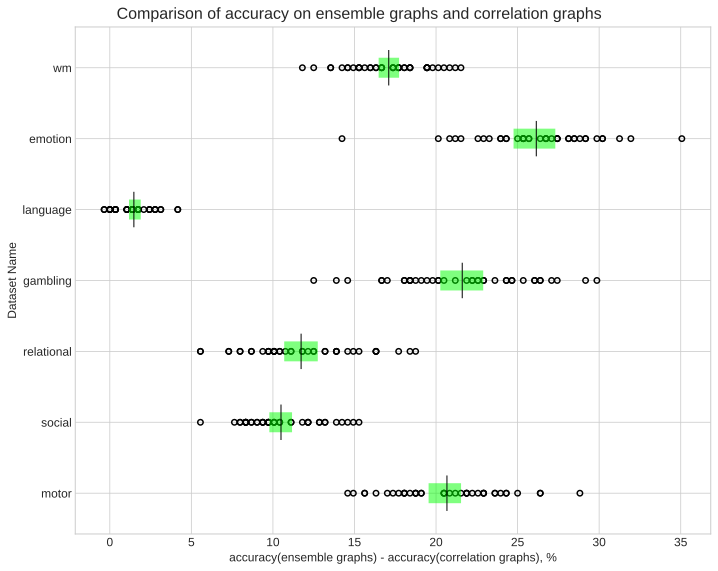

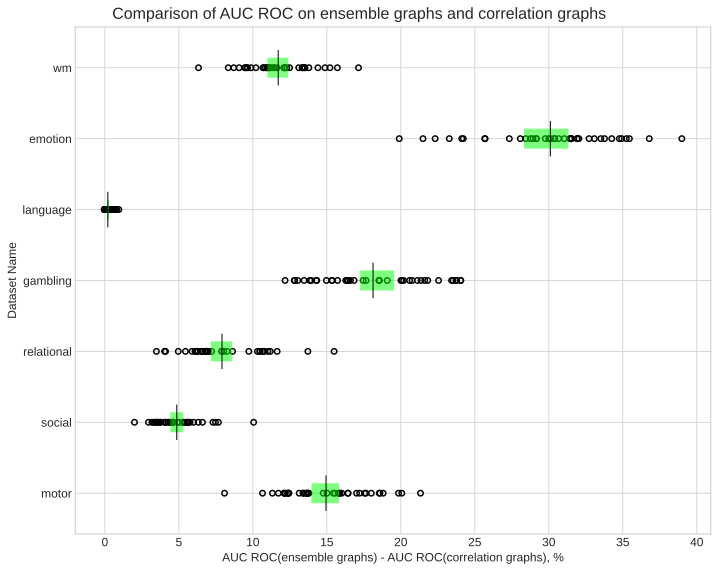

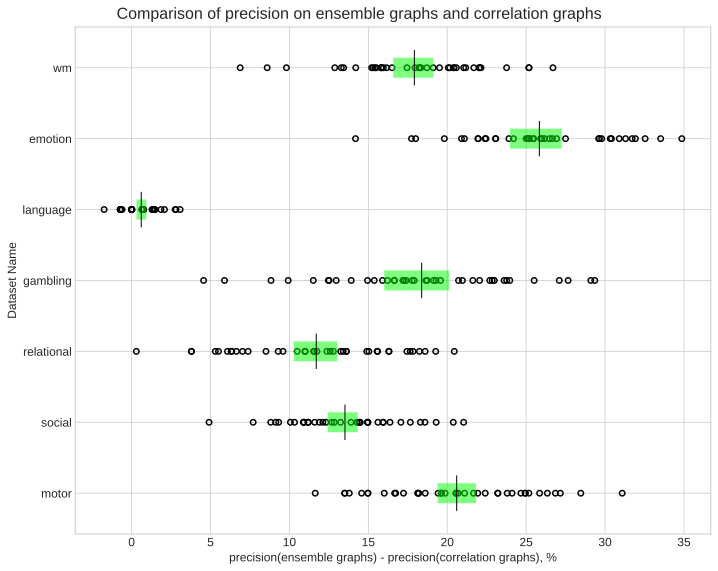

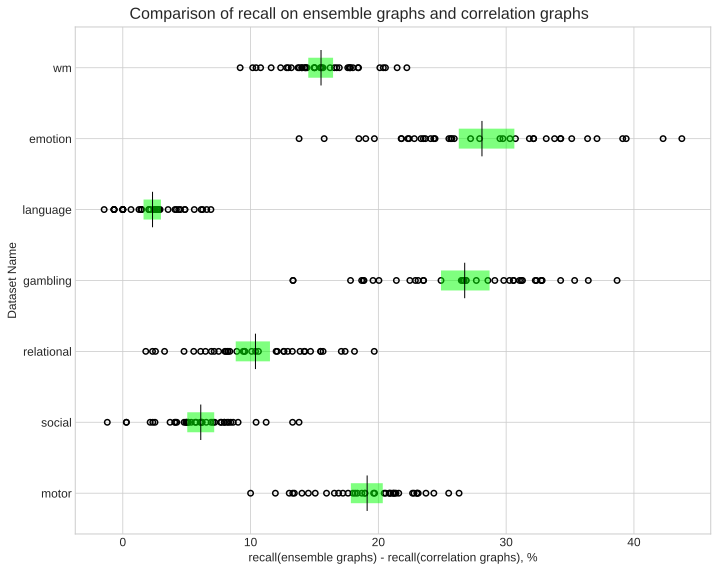

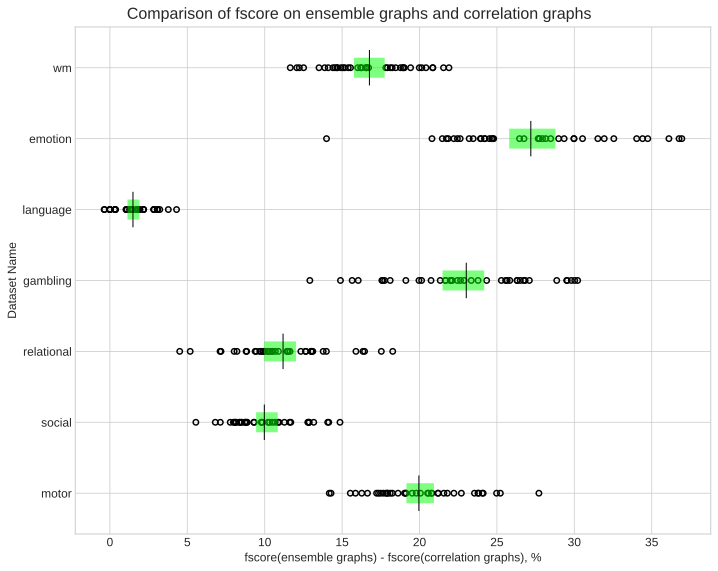

In [37]:
for metric in metric_df['metric'].unique():
    # Задаем параметры рисунка
    @set_plot_env(fig_in_inches=(10, 8),
                  num_rows=1,
                  num_cols=1,
                  xlabel=f'{metric}(ensemble graphs) - {metric}(correlation graphs), %',
                  show_legend=False,
                  title=f'Comparison of {metric} on ensemble graphs and correlation graphs',
                  title_pad=0.8,
                  ylabel='Dataset Name',
                  use_sharey=True,
                  fname=f'compare_{metric}'
             )
    def plot_fig(fig, ax, metric_df, metric):
        
        df_curr = metric_df.query(f'metric == "{metric}"').copy()
        grouped = df_curr.groupby('dataset', sort=False)
        means = grouped['delta'].mean()
        df_curr.loc[:, 'group_num'] = grouped.ngroup()
        # Уникальные значения в порядке следования в DataFrame
        df_stat = df_curr[['dataset', 'delta_ci_m', 'delta_ci_p', 'color', 'group_num']].drop_duplicates()
        datasets = df_stat['dataset']
        y_pos = df_stat['group_num'].to_numpy()
        # Create a plot with categorical y-axis
        plt.yticks(y_pos, datasets)
        ax.hlines(y_pos,
                  df_stat['delta_ci_m'],
                  df_stat['delta_ci_p'],
                  linewidth=20,
                  color=df_stat['color']
                  )
        ax.vlines(means,
                  y_pos - 0.25,
                  y_pos + 0.25,
                  linewidth=1,
                  color='black'
                  #color=remove_transparency(df_stat['color'])
                 )
        ax.scatter(df_curr['delta'],
                   df_curr['group_num'],
                   s=30,
                   linewidths=1.5,
                   facecolors='none',
                   edgecolors='k'
                   )
        
    plot_fig(metric_df=metric_df, metric=metric)